In [1]:
import os
import pandas as pd
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns

c:\Users\user\miniconda3\envs\lda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return filtered_tokens

In [3]:
# Load dataset
df = pd.read_csv("Domestic_Airline.csv")

# Preprocess the text data
df['processed_text'] = df['Review'].dropna().apply(preprocess_text)

# Ensure that only iterable (i.e., list) entries are kept, and filter out non-iterable values like float
df = df[df['processed_text'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

# Preprocess each document
documents = df['Review'].dropna().tolist()
tokenized_documents = [preprocess_text(doc) for doc in documents]


In [4]:
dictionary = corpora.Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]
w2v_model = Word2Vec(sentences=df['processed_text'], window=5, vector_size=100, min_count=1)
num_topics = 5
coherence_metric = 'c_v'

In [5]:
# ------------------- Traditional LDA -------------------------
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
lda_coherence_model = CoherenceModel(model=lda_model, texts=df['processed_text'], dictionary=dictionary, coherence=coherence_metric)
lda_coherence = lda_coherence_model.get_coherence()

In [6]:
# Compute the dominant topic for each document
def get_dominant_topic_lda(lda_model, corpus):
    dominant_topics = []
    for doc_bow in corpus:
        topic_probs = lda_model.get_document_topics(doc_bow)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]  # Get topic with highest probability
        dominant_topics.append(dominant_topic)
    return dominant_topics


In [7]:
# Compute coherence per topic
topics_coherence = lda_coherence_model.get_coherence_per_topic()
print("\nTraditional LDA Topic Coherence Scores:")
for idx, score in enumerate(topics_coherence):
    print(f"Topic {idx}: {score:.4f}")
    
lda_coherence = lda_coherence_model.get_coherence()  # Overall coherence score
print(f"\nTraditional LDA Overall Coherence Score: {lda_coherence:.4f}")

# Get dominant topics for LDA
dominant_topics_lda = get_dominant_topic_lda(lda_model, corpus)

# Count documents associated with each topic
topic_doc_count_lda = np.bincount(dominant_topics_lda, minlength=num_topics)
print("\nDocument count for each LDA topic:")
for idx, count in enumerate(topic_doc_count_lda):
    print(f"Topic {idx}: {count} documents")


Traditional LDA Topic Coherence Scores:
Topic 0: 0.2697
Topic 1: 0.3079
Topic 2: 0.3714
Topic 3: 0.2977
Topic 4: 0.2631

Traditional LDA Overall Coherence Score: 0.3020

Document count for each LDA topic:
Topic 0: 240 documents
Topic 1: 773 documents
Topic 2: 253 documents
Topic 3: 494 documents
Topic 4: 450 documents


In [8]:
# Ensure the output directory exists
output_dir = 'pca_visualizations'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


def visualize_topics_3D_pca(document_topic_matrix, dominant_topics, num_topics, title, output_path):
    # Apply PCA to reduce the dimensionality to 3D
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(document_topic_matrix)

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a color map for each topic
    colors = plt.get_cmap('tab10', num_topics)  # Use plt.get_cmap instead of plt.cm.get_cmap

    for topic in range(num_topics):
        indices = [i for i, dom_topic in enumerate(dominant_topics) if dom_topic == topic]
        ax.scatter(pca_result[indices, 0], pca_result[indices, 1], pca_result[indices, 2], 
                   color=colors(topic), label=f'Topic {topic}')

    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')

    plt.legend()
    
    # Save the plot to the provided output path
    plt.savefig(output_path)
    plt.show()

    plt.close()  # Close the plot to free up memory

    print(f"3D PCA visualization saved at {output_path}")



Visualizing Traditional LDA Topic-Document Mapping with 3D PCA:


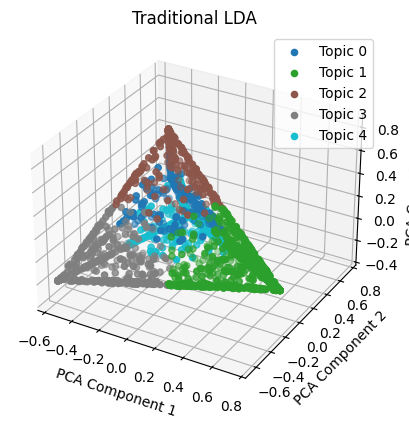

3D PCA visualization saved at pca_visualizations\lda_visualization.png


In [9]:
print("\nVisualizing Traditional LDA Topic-Document Mapping with 3D PCA:")

# Ensure you have the LDA document-topic matrix and dominant topics
document_topic_distribution_lda = np.array([lda_model.get_document_topics(bow, minimum_probability=0) for bow in corpus])
lda_document_topic_matrix = np.array([[prob for _, prob in doc] for doc in document_topic_distribution_lda])

# Output path for the saved image
output_path_lda = os.path.join(output_dir, 'lda_visualization.png')

# Call the visualization function and provide the output path
visualize_topics_3D_pca(lda_document_topic_matrix, dominant_topics_lda, num_topics, "Traditional LDA", output_path_lda)


In [10]:
# ------------------- LDA + Word2Vec Coherence -------------------------
def compute_w2v_weighted_topic_matrix(lda_model, w2v_model, num_topics, dictionary):
    topics = lda_model.show_topics(num_topics=num_topics, formatted=False)
    topic_similarity_matrix = []
    for topic in topics:
        topic_words = [word for word, _ in topic[1]]
        topic_word_vectors = [w2v_model.wv[word] for word in topic_words if word in w2v_model.wv]
        similarity_matrix = cosine_similarity(topic_word_vectors)
        avg_similarity = np.mean(similarity_matrix)
        topic_similarity_matrix.append(avg_similarity)
    return topic_similarity_matrix

# LDA + Word2Vec Coherence Scores
def lda_with_word2vec_coherence(lda_model, w2v_model, num_topics, dictionary):
    topic_similarities = compute_w2v_weighted_topic_matrix(lda_model, w2v_model, num_topics, dictionary)
    print("\nLDA + Word2Vec Enhanced Topic Coherence Scores:")
    for idx, similarity in enumerate(topic_similarities):
        print(f"Topic {idx}: {similarity:.4f}")
    overall_similarity = np.mean(topic_similarities)
    print(f"\nLDA + Word2Vec Enhanced Overall Coherence Score: {overall_similarity:.4f}")
    return topic_similarities, overall_similarity

In [11]:
# ------------------- LDA + Word2Vec Document-Topic Mapping -------------------------
def get_dominant_topic_lda_w2v(lda_model, corpus, w2v_model, dictionary, num_topics):
    dominant_topics = []
    for doc_bow in corpus:
        # Get traditional LDA topic probabilities for each document
        topic_probs = lda_model.get_document_topics(doc_bow)
        
        # Get the top words from each topic using LDA
        topic_words = []
        for topic_num, _ in topic_probs:
            words = [word for word, _ in lda_model.show_topic(topic_num)]
            topic_words.append(words)
        
        # Compute Word2Vec similarity for each topic's top words
        topic_similarities = []
        for words in topic_words:
            word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
            if len(word_vectors) > 1:
                similarity_matrix = cosine_similarity(word_vectors)
                avg_similarity = np.mean(similarity_matrix)
            else:
                avg_similarity = 0  # Handle case where a topic has fewer valid word embeddings
            topic_similarities.append(avg_similarity)
        
        # Choose the topic with the highest similarity
        dominant_topic = np.argmax(topic_similarities)
        dominant_topics.append(dominant_topic)
    
    return dominant_topics

# Get dominant topics for LDA + Word2Vec
dominant_topics_lda_w2v = get_dominant_topic_lda_w2v(lda_model, corpus, w2v_model, dictionary, num_topics)


In [12]:
lda_w2v_topic_coherence, lda_w2v_overall_coherence = lda_with_word2vec_coherence(lda_model, w2v_model, num_topics, dictionary)

# Count documents associated with each topic in LDA + Word2Vec
topic_doc_count_lda_w2v = np.bincount(dominant_topics_lda_w2v, minlength=num_topics)
print("\nDocument count for each LDA + Word2Vec topic:")
for idx, count in enumerate(topic_doc_count_lda_w2v):
    print(f"Topic {idx}: {count} documents")



LDA + Word2Vec Enhanced Topic Coherence Scores:
Topic 0: 0.8674
Topic 1: 0.9157
Topic 2: 0.8926
Topic 3: 0.9185
Topic 4: 0.9003

LDA + Word2Vec Enhanced Overall Coherence Score: 0.8989

Document count for each LDA + Word2Vec topic:
Topic 0: 1043 documents
Topic 1: 825 documents
Topic 2: 215 documents
Topic 3: 127 documents
Topic 4: 0 documents



Visualizing LDA + Word2Vec Topic-Document Mapping with 3D PCA:


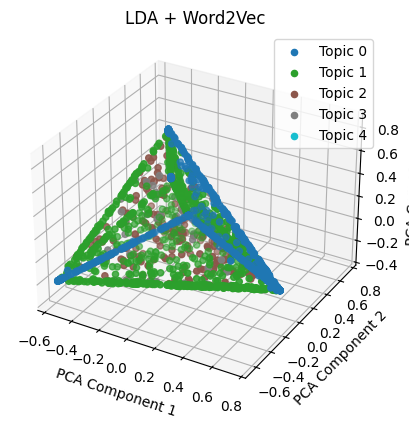

3D PCA visualization saved at pca_visualizations\EW-LDA_visualization.png


In [13]:
print("\nVisualizing LDA + Word2Vec Topic-Document Mapping with 3D PCA:")

# Ensure you have the LDA + Word2Vec document-topic matrix and dominant topics
document_topic_distribution_lda_w2v = np.array([lda_model.get_document_topics(bow, minimum_probability=0) for bow in corpus])
lda_w2v_document_topic_matrix = np.array([[prob for _, prob in doc] for doc in document_topic_distribution_lda_w2v])

# Output path for the saved image
output_path_lda = os.path.join(output_dir, 'EW-LDA_visualization.png')

# Call the visualization function and save the image
visualize_topics_3D_pca(lda_w2v_document_topic_matrix, dominant_topics_lda_w2v, num_topics, "LDA + Word2Vec", output_path_lda)

In [14]:
# ------------------- Standard NMF -------------------------
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(doc) for doc in tokenized_documents])
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

c:\Users\user\miniconda3\envs\lda\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
# Extract topics from NMF for Coherence Calculation
def extract_nmf_topics(model, feature_names, no_top_words=15):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-no_top_words:][::-1]]
        topics.append(top_words)
    return topics


In [16]:
nmf_standard_model = NMF(n_components=num_topics, max_iter=400, random_state=42)
nmf_standard_model.fit(tfidf_matrix)
nmf_standard_topics = extract_nmf_topics(nmf_standard_model, tfidf_vocab)

nmf_standard_coherence_model = CoherenceModel(topics=nmf_standard_topics, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
nmf_standard_coherence = nmf_standard_coherence_model.get_coherence()
nmf_standard_coherence_topic_scores = nmf_standard_coherence_model.get_coherence_per_topic()

# Compute the dominant topic for each document in Standard NMF
nmf_topic_distribution = nmf_standard_model.transform(tfidf_matrix)
dominant_topics_nmf = np.argmax(nmf_topic_distribution, axis=1)

c:\Users\user\miniconda3\envs\lda\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


In [17]:
print("\nStandard NMF Topic-wise Coherence Scores:")
for idx, score in enumerate(nmf_standard_coherence_topic_scores, 1):
    print(f"Topic {idx}: {score:.4f}")
print(f"\nStandard NMF Overall Coherence Score: {nmf_standard_coherence:.4f}")

# Count documents associated with each topic in Standard NMF
topic_doc_count_nmf = np.bincount(dominant_topics_nmf, minlength=num_topics)
print("\nDocument count for each Standard NMF topic:")
for idx, count in enumerate(topic_doc_count_nmf):
    print(f"Topic {idx}: {count} documents")



Standard NMF Topic-wise Coherence Scores:
Topic 1: 0.5244
Topic 2: 0.2837
Topic 3: 0.2815
Topic 4: 0.4713
Topic 5: 0.4518

Standard NMF Overall Coherence Score: 0.4026

Document count for each Standard NMF topic:
Topic 0: 233 documents
Topic 1: 735 documents
Topic 2: 169 documents
Topic 3: 111 documents
Topic 4: 962 documents



Visualizing Standard NMF Topic-Document Mapping with 3D PCA:


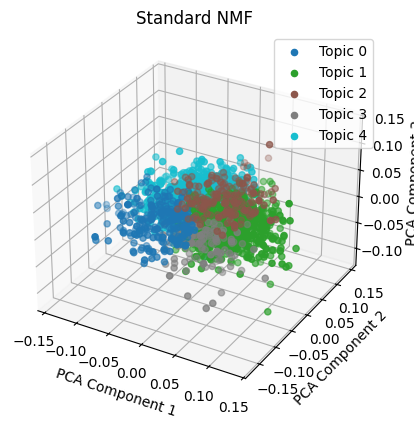

3D PCA visualization saved at pca_visualizations\NMF_visualization.png


In [18]:
# Visualization for Standard NMF with 3D PCA
print("\nVisualizing Standard NMF Topic-Document Mapping with 3D PCA:")

# Ensure you have the NMF document-topic matrix and dominant topics
# Output path for the saved image
output_path_nmf = os.path.join(output_dir, 'NMF_visualization.png')

# Call the visualization function and save the image
visualize_topics_3D_pca(nmf_topic_distribution, dominant_topics_nmf, num_topics, "Standard NMF", output_path_nmf)


In [19]:
# ------------------- TF-IDF Weighted Word2Vec + NMF -------------------------
def get_document_embedding(doc, tfidf_vocab, tfidf_scores):
    embeddings = []
    for word in doc:
        if word in w2v_model.wv and word in tfidf_vocab:
            word_idx = np.where(tfidf_vocab == word)[0][0]
            embeddings.append(w2v_model.wv[word] * tfidf_scores[word_idx])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

In [20]:
document_embeddings_list = []
for doc in tokenized_documents:
    tfidf_scores = tfidf_vectorizer.transform([' '.join(doc)]).toarray().flatten()
    embedding = get_document_embedding(doc, tfidf_vocab, tfidf_scores)
    document_embeddings_list.append(embedding)
document_embeddings = np.array(document_embeddings_list)
document_embeddings = np.abs(document_embeddings)

nmf_word2vec_model = NMF(n_components=num_topics, max_iter=400, random_state=42)
nmf_word2vec_model.fit(document_embeddings)


c:\Users\user\miniconda3\envs\lda\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


NMF(max_iter=400, n_components=5, random_state=42)

In [21]:
def get_word2vec_nmf_topics(model, tokenized_docs, no_top_words=15):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_word_indices = topic.argsort()[-no_top_words:][::-1]
        all_words = set(word for doc in tokenized_docs for word in doc)
        topic_words = [list(all_words)[i] for i in top_word_indices if list(all_words)[i] in w2v_model.wv]
        topics.append(topic_words)
    return topics


In [22]:
nmf_word2vec_topics = get_word2vec_nmf_topics(nmf_word2vec_model, tokenized_documents, no_top_words=15)
nmf_word2vec_coherence_model = CoherenceModel(topics=nmf_word2vec_topics, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
nmf_word2vec_coherence = nmf_word2vec_coherence_model.get_coherence()
nmf_word2vec_coherence_topic_scores = nmf_word2vec_coherence_model.get_coherence_per_topic()


# Compute the dominant topic for each document in TF-IDF Word2Vec NMF
nmf_word2vec_topic_distribution = nmf_word2vec_model.transform(document_embeddings)
dominant_topics_word2vec_nmf = np.argmax(nmf_word2vec_topic_distribution, axis=1)

In [23]:
print("\nTF-IDF Weighted Word2Vec NMF Topic-wise Coherence Scores:")
for idx, score in enumerate(nmf_word2vec_coherence_topic_scores, 1):
    print(f"Topic {idx}: {score:.4f}")
print(f"\nTF-IDF Weighted Word2Vec NMF Overall Coherence Score: {nmf_word2vec_coherence:.4f}")

# Count documents associated with each topic in TF-IDF Weighted Word2Vec NMF
topic_doc_count_word2vec_nmf = np.bincount(dominant_topics_word2vec_nmf, minlength=num_topics)
print("\nDocument count for each TF-IDF Weighted Word2Vec NMF topic:")
for idx, count in enumerate(topic_doc_count_word2vec_nmf):
    print(f"Topic {idx}: {count} documents")




TF-IDF Weighted Word2Vec NMF Topic-wise Coherence Scores:
Topic 1: 0.6575
Topic 2: 0.6827
Topic 3: 0.6776
Topic 4: 0.6827
Topic 5: 0.6391

TF-IDF Weighted Word2Vec NMF Overall Coherence Score: 0.6679

Document count for each TF-IDF Weighted Word2Vec NMF topic:
Topic 0: 1578 documents
Topic 1: 28 documents
Topic 2: 445 documents
Topic 3: 0 documents
Topic 4: 159 documents



Visualizing TF-IDF Weighted Word2Vec NMF Topic-Document Mapping with 3D PCA:


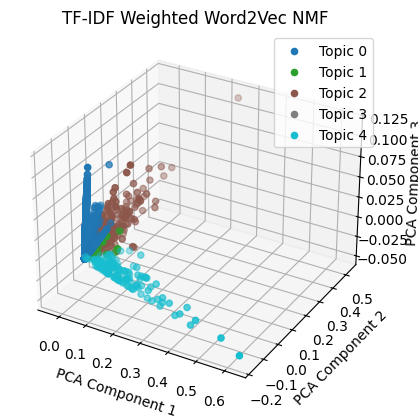

3D PCA visualization saved at pca_visualizations\TWE-NMF_visualization.png


In [24]:
# Visualization for TF-IDF Weighted Word2Vec NMF with 3D PCA
print("\nVisualizing TF-IDF Weighted Word2Vec NMF Topic-Document Mapping with 3D PCA:")

# Ensure you have the TF-IDF Weighted Word2Vec NMF document-topic matrix and dominant topics
# Output path for the saved image
output_path_twe_nmf = os.path.join(output_dir, 'TWE-NMF_visualization.png')

# Call the visualization function and save the image
visualize_topics_3D_pca(nmf_word2vec_topic_distribution, dominant_topics_word2vec_nmf, num_topics, "TF-IDF Weighted Word2Vec NMF", output_path_twe_nmf)
